In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import sys
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA

import DBCV 
print(DBCV.__file__)
from DBCV import DBCV 


c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\DBCV\__init__.py


In [2]:
data = pd.read_csv('../dataset/CC GENERAL.csv')
data.head(5)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [4]:
# This information of CUST_ID is not necessary
data = data.drop('CUST_ID', axis=1)

In [5]:
# Functions for EDA
def remove_duplicates(df):
    if(any(df.duplicated())):
        return df.drop_duplicates(keep='first')
    
    print('No duplicates')
    return df

def count_nulls(df):
    # Count the number of rows with null values
    num_rows_with_nulls = df.isnull().any(axis=1).sum()
    
    # Count the number of null values in each column
    null_counts = df.isnull().sum()
    
    return (num_rows_with_nulls, null_counts)


def plot_correlation(df, column):
    # Drop rows with missing values in the specified column
    df = df.dropna(subset=[column])
    
    # Calculate the correlation coefficients
    corr = df.corr()[[column]]
    
    # Create a bar plot
    ax = sns.barplot(data=corr, x=column, y=corr.index, orient='h')
    ax.set_title(f'Correlation between {column} and other columns')
    
    # Show the plot
    plt.show()

In [6]:
# Check for duplicates and null values in columns
data = remove_duplicates(df=data)
count_nulls(data)

No duplicates


(314,
 BALANCE                               0
 BALANCE_FREQUENCY                     0
 PURCHASES                             0
 ONEOFF_PURCHASES                      0
 INSTALLMENTS_PURCHASES                0
 CASH_ADVANCE                          0
 PURCHASES_FREQUENCY                   0
 ONEOFF_PURCHASES_FREQUENCY            0
 PURCHASES_INSTALLMENTS_FREQUENCY      0
 CASH_ADVANCE_FREQUENCY                0
 CASH_ADVANCE_TRX                      0
 PURCHASES_TRX                         0
 CREDIT_LIMIT                          1
 PAYMENTS                              0
 MINIMUM_PAYMENTS                    313
 PRC_FULL_PAYMENT                      0
 TENURE                                0
 dtype: int64)

In [7]:
# Retrieve the rows will null value in their columns.
# The easy way out will be to remove those rows but we will look at how we can fill in the missing values.
null_rows = data[data.isnull().any(axis=1)]
null_rows.head(5)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3,1666.670542,0.636364,1499.0,1499.0,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.0,12
45,2242.311686,1.000000,437.0,97.0,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.000000,NaN,0.0,12
47,3910.111237,1.000000,0.0,0.0,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.000000,NaN,0.0,12
54,6.660517,0.636364,310.0,0.0,310.0,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,NaN,0.0,12
55,1311.995984,1.000000,1283.9,1283.9,0.0,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,6000.0,0.000000,NaN,0.0,12


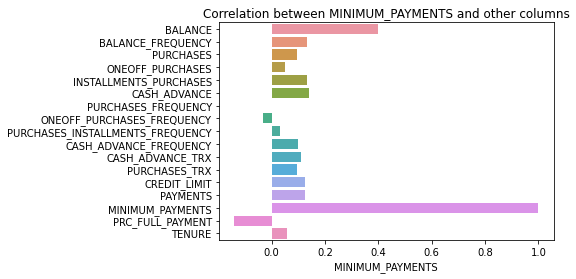

In [8]:
# Lets look at the correlation data to see if we can estimate the missing values
plot_correlation(data, 'MINIMUM_PAYMENTS')

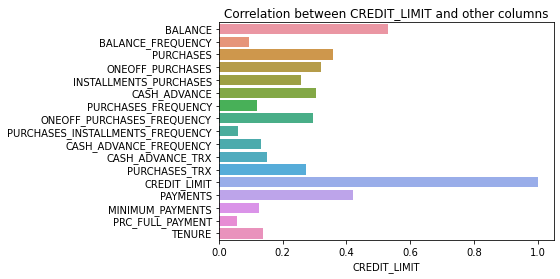

In [9]:
plot_correlation(data, 'CREDIT_LIMIT')

In [10]:
"""
In my opinion, none of the columns form a strong correlation with 'MINIMUM_PAYMENT' and 'CREDIT_LIMIT'. 
The threshold in my heart is about 0.8 
What we can do is use mean or median imputation, which is also simpler.

"""
def plot_missing_col_histogram(df, column, ylabel='FREQUENCY'):
    # Drop rows with missing values in the specified column
    df = df.dropna(subset=[column])
    
    # Create a histogram with a density curve
    sns.distplot(df[column], hist=True, kde=True)
    
    # Set the labels and title
    plt.xlabel(column)
    plt.ylabel(ylabel)
    plt.title(f'Histogram of {column}')
    
    # Show the plot
    plt.show()

C:\Users\JoeTe\AppData\Local\Temp\ipykernel_12396\4044767199.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], hist=True, kde=True)


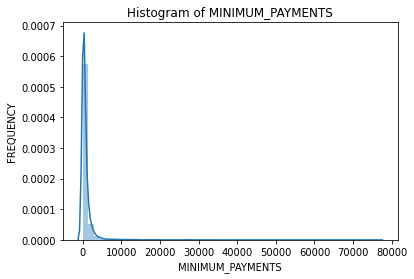

In [11]:
plot_missing_col_histogram(data, 'MINIMUM_PAYMENTS')

C:\Users\JoeTe\AppData\Local\Temp\ipykernel_12396\4044767199.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], hist=True, kde=True)


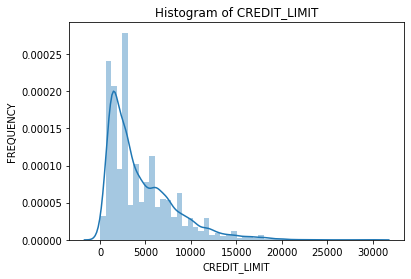

In [12]:
plot_missing_col_histogram(data, 'CREDIT_LIMIT')

In [13]:
# From the histogram plots, we can see that the distribution of the data in the columns 'MINIMUM_PAYMENTS' and 'CREDIT_LIMIT' is skewd
# Using medium to replace the missing values will be a good choice as they are less likely to be affected by outliers or extreme values

print("Median value of MINIMUM_PAYMENTS: ", data['MINIMUM_PAYMENTS'].median())
print("Median value of CREDIT_LIMIT: ", data['CREDIT_LIMIT'].median())

data = data.fillna(data.median())

Median value of MINIMUM_PAYMENTS:  312.343947
Median value of CREDIT_LIMIT:  3000.0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [15]:
def find_outliers(df):
    outliers = {}
    fig, axs = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 5*len(df.columns)))
    
    # Loop through each column in the DataFrame
    for i, col in enumerate(df.columns):
        # Check if the column is numeric
        if df[col].dtype in ["int64", "float64"]:
            # Calculate the IQR
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            # Calculate the lower and upper bounds
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Find the outlier indices
            outlier_indexes = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
            
            # Add the outlier information to the dictionary
            outliers[col] = {
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'outlier_indexes': outlier_indexes,
                'outlier_values': df.loc[outlier_indexes, col].tolist()
            }
            
            # Plot the boxplot
            axs[i].boxplot(df[col], vert=False)
            axs[i].set_title(col)
    
    plt.show()
    return outliers


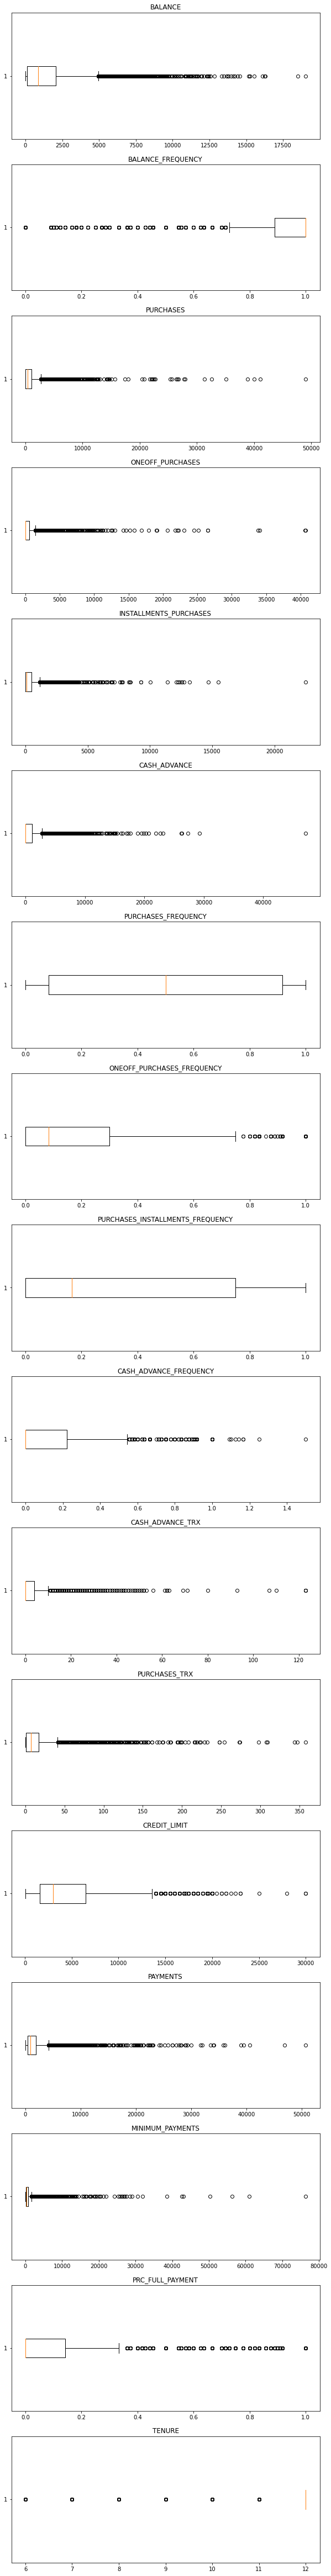

Column: BALANCE
Outlier range: < -2760.5052645 or > 4942.9272155
Outlier values: [6886.213231, 6369.531318, 5368.571219, 7152.864372, 12136.21996, 6732.823064, 7427.076941, 6269.418144, 5315.945594, 5493.90406, 5487.683724, 5860.433624, 6593.820644, 7069.950386, 8181.251131, 6110.265264, 9381.255094, 4986.400804, 6644.201651, 5322.994094, 6458.56209, 8504.876253, 14224.11541, 11167.23403, 9354.06045, 19043.13856, 5347.814547, 10598.46777, 7679.62904, 13673.07961, 5837.105453, 5800.587339, 11972.01104, 5462.897068, 5588.846272, 5698.539876, 8350.145568, 7201.736985, 6467.885013, 5635.860679, 9047.621884, 5431.622968, 6571.484039, 7623.224897, 9612.21512, 7938.559134, 5335.302925, 5570.190127, 7755.698607, 8097.334733, 5131.319584, 5265.763713, 7645.108427, 5469.851311, 5790.930626, 5547.092593, 9261.310686, 9206.811696, 6719.376505, 8939.461145, 5135.604593, 5747.761139, 7760.940543, 6388.108487, 8806.866629, 11278.95243, 12474.72954, 7957.017218, 11209.37076, 5066.744231, 5523.999416, 

In [16]:
outliers = find_outliers(data)
for col, info in outliers.items():
    print(f'Column: {col}')
    print(f'Outlier range: < {info["lower_bound"]} or > {info["upper_bound"]}')
    # print(f'Outlier rows: {info["outlier_indexes"]}')
    print(f'Outlier values: {info["outlier_values"]}')

#### Observations 
 All the columns have a ton of outliers, removing them is not going to help 

# EDA

In [17]:
# Now that we sort of clean the dataset, lets do some exploration
data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.282473,1733.143852,844.906767,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.646702,2895.063757,2332.792322,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,170.857654,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,788.713501,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [18]:
def plot_histograms(df, ncols=4):
    # Calculate the number of rows to use in the layout of the plots
    nrows = (len(df.columns) + ncols - 1) // ncols
    
    # Create a figure and axes
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
    
    # Flatten the axes array
    axes = axes.flatten()
    
    # Create a histogram for each column
    for i, column in enumerate(df.columns):
        ax = axes[i]
        sns.distplot(df[column].dropna(), ax=ax, hist=True, kde=True)
        #ax.set_title(column)
    
    # Show the plots
    plt.show()

C:\Users\JoeTe\AppData\Local\Temp\ipykernel_12396\2271981933.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column].dropna(), ax=ax, hist=True, kde=True)
C:\Users\JoeTe\AppData\Local\Temp\ipykernel_12396\2271981933.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column].dropna()

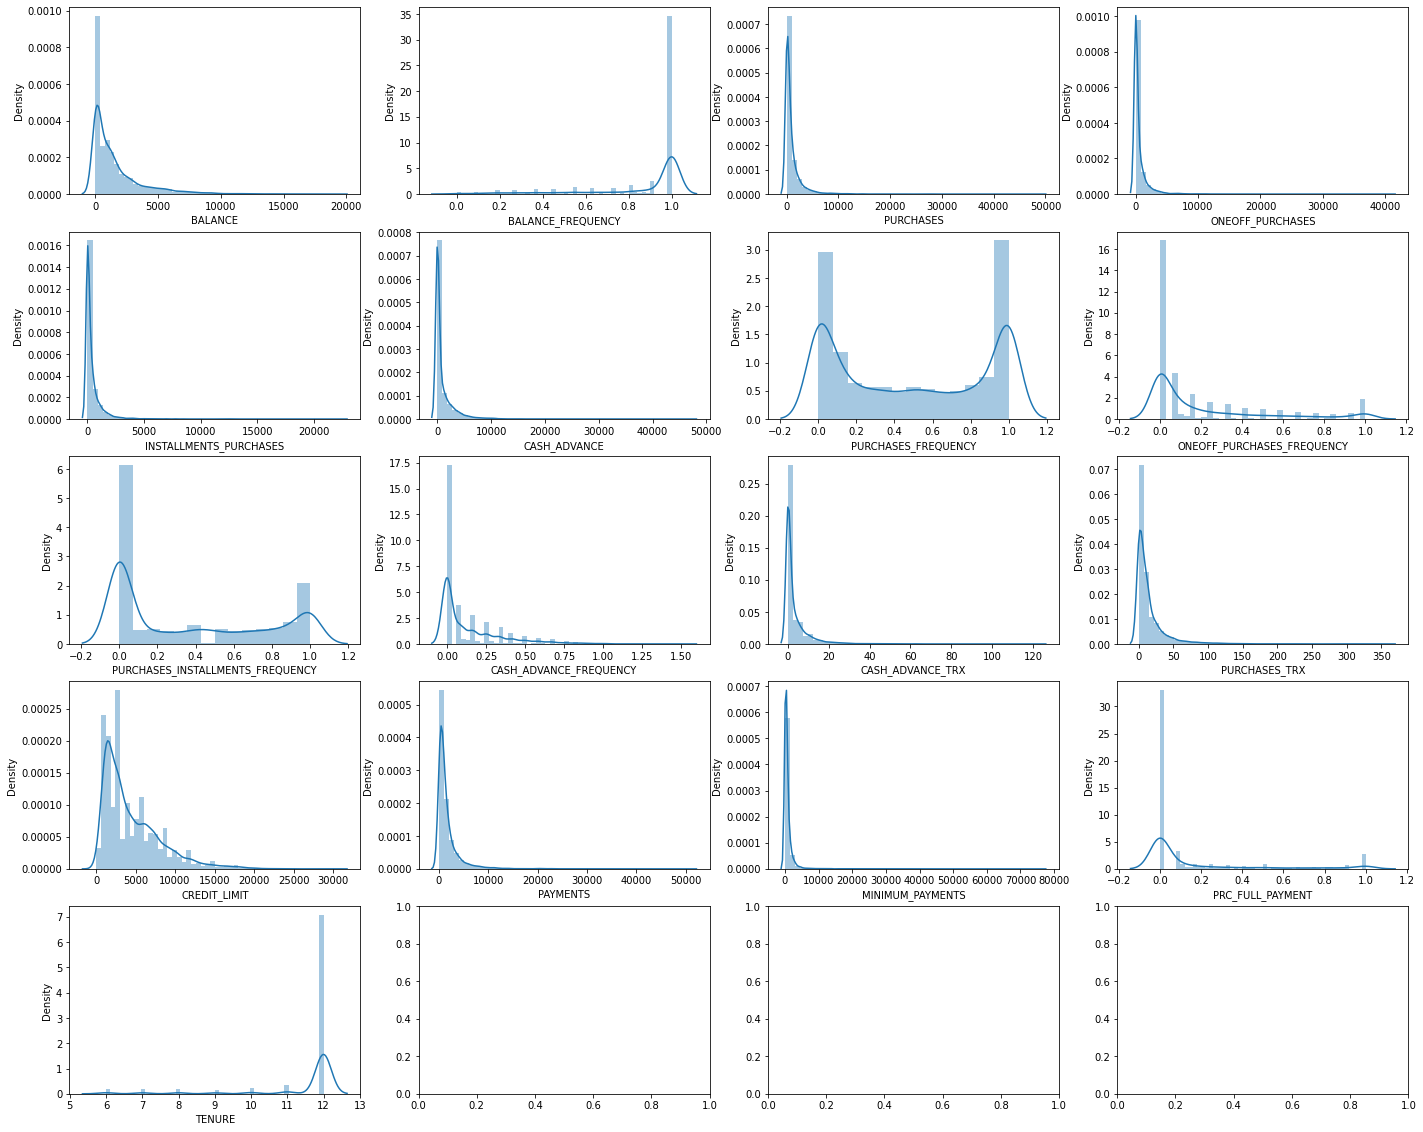

In [19]:
plot_histograms(data)

In [20]:
# Lets look at correlation
def plot_corr_heatmap(df, figsize=(15, 8)):
    # Create a figure with the specified size
    plt.figure(figsize=figsize)
    
    # Calculate the correlation matrix
    corr = df.corr()
    
    # Create a heatmap
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')

    # Show the plot
    plt.show()

def plot_corr_scatter_matrix(df):
    # Create a pairplot
    sns.pairplot(df)
    
    # Show the plot
    plt.show()


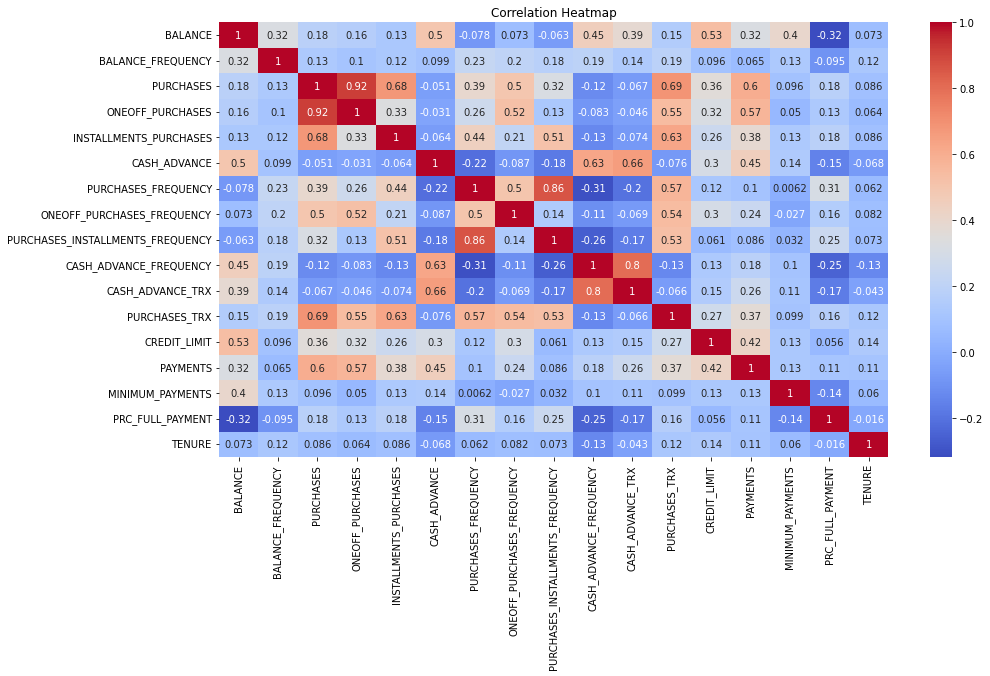

In [21]:
plot_corr_heatmap(data)

In [22]:
# plot_corr_scatter_matrix(data)

In [23]:
def min_max_scale(df):
   
    scaler = MinMaxScaler()
    
    # Fit the scaler to the data
    scaler.fit(df)
    
    # Transform the data
    scaled_data = scaler.transform(df)
    
    
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
    
    return scaled_df

def standard_scale(df):
   
    scaler = StandardScaler()
    
    # Fit the scaler to the data
    scaler.fit(df)
    
    # Transform the data
    scaled_data = scaler.transform(df)
    
    
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
    
    return scaled_df

In [24]:
min_max_scaled_data = min_max_scale(data)
standard_scaled_data = standard_scale(data)


# PCA

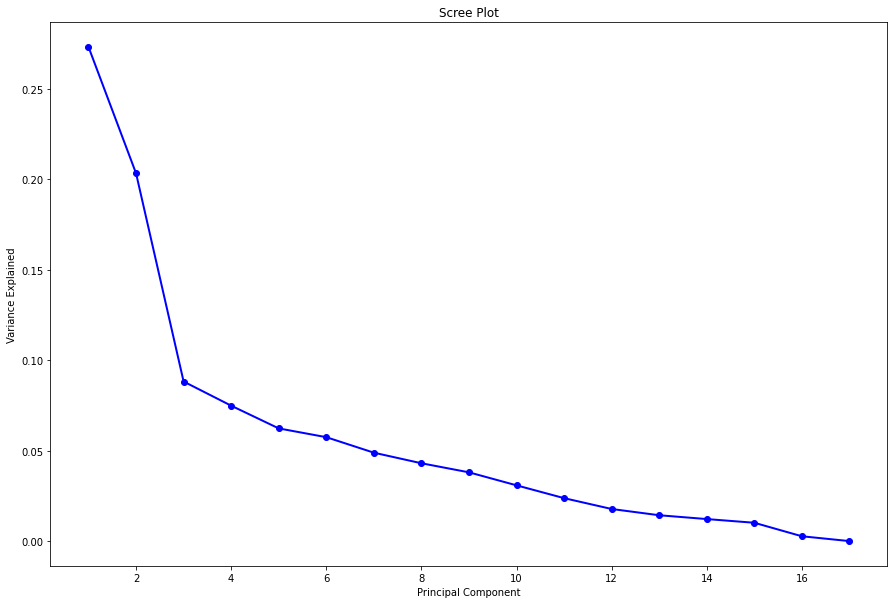

In [25]:
# Scree Plot to determine PCA n components
# Assuming that 'data' is your dataset
pca = PCA(random_state=24).fit(standard_scaled_data)
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.savefig('../visualisations/K-means/ScreePlot for Dataset 1.png')  
plt.show()

In [26]:
# Based on the scree plot, we take 2, the point before the elbow
pca = PCA(n_components=2, random_state=24)
transformed_scaled_data = pca.fit_transform(standard_scaled_data )

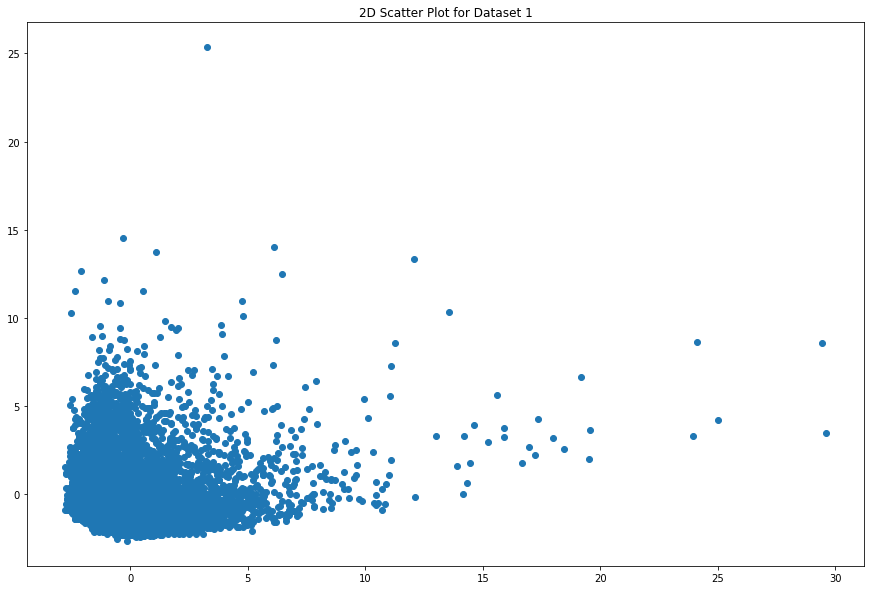

In [27]:
plt.figure(figsize=(15,10))
plt.scatter(transformed_scaled_data[:, 0], transformed_scaled_data[:, 1])
plt.title('2D Scatter Plot for Dataset 1')  # Add your title
plt.savefig('../visualisations/K-means/2D SCatter Plot for Dataset 1.png')  
plt.show()
plt.show()

# K-means Clustering

In [28]:
def kmeans_elbow_method(data, max_k=30, figsize=(15, 8)):
    ssd = []
    silhouette_scores = []
    plt.figure(figsize=figsize)
    # Loop through different values of k
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        
        # Fit the k-means clustering model to the data
        kmeans.fit(data)
        
        # Calculate the sum of squared distances
        ssd.append(kmeans.inertia_)
        
        # Calculate the average silhouette score
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Sum of squared distances', color='b')
    ax1.plot(range(2, max_k+1), ssd, 'bo-')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette score', color='r')
    ax2.plot(range(2, max_k+1), silhouette_scores, 'ro-')
    
    fig.tight_layout()
    
    plt.savefig('../visualisations/K-means/dataset1_elbow_curve.png')
    plt.show()

c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

<Figure size 1080x576 with 0 Axes>

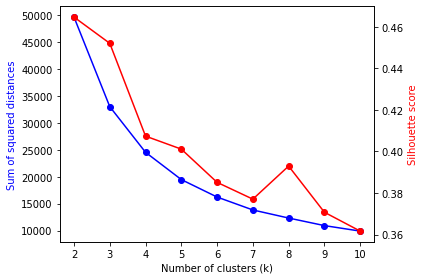

In [29]:
kmeans_elbow_method(transformed_scaled_data, max_k=10)

c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


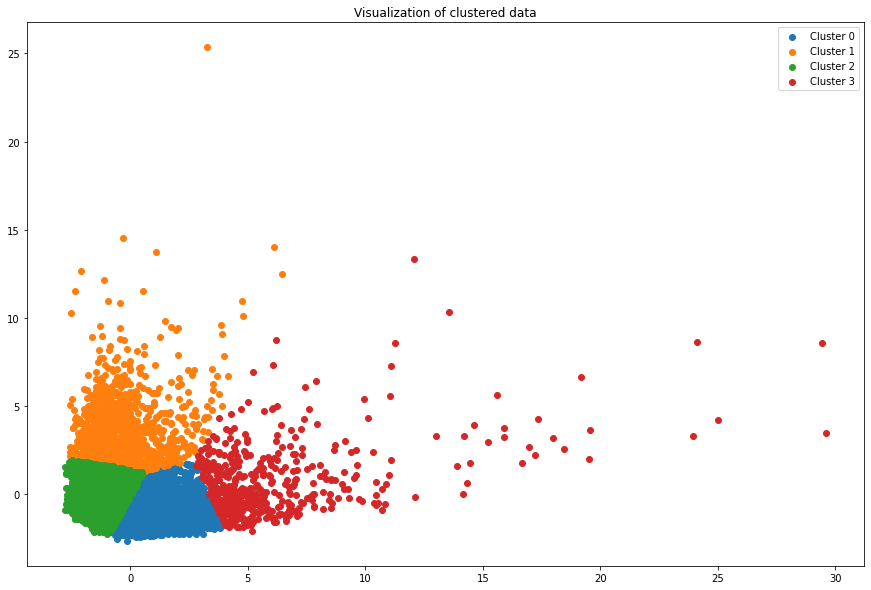

In [30]:
# Number of cluster for K-means to be 4 or 5
k = 4
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(transformed_scaled_data)
cluster_labels = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_
#print(kmeans_centroids)
kmeans_silhouette = silhouette_score(transformed_scaled_data, cluster_labels)
plt.figure(figsize=(15,10))
for i in range(k):
    plt.scatter(transformed_scaled_data[cluster_labels == i, 0], transformed_scaled_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()

# Plot the centroids

#plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of clustered data')
plt.savefig('../visualisations/K-means/dataset1_cluster.png')
plt.show()

In [31]:
kmeans_data = data.copy()
kmeans_data['kmeans_cluster'] = kmeans.labels_

In [32]:
# for c in kmeans_data:
#     grid= sns.FacetGrid(kmeans_data, col='kmeans_cluster')
#     grid.map(plt.hist, c)

In [33]:
cluster_kmeans = kmeans_data.groupby('kmeans_cluster').mean().T
cm = sns.light_palette("blue", as_cmap=True)
cluster_kmeans = cluster_kmeans.style.background_gradient(cmap=cm)
cluster_kmeans

kmeans_cluster,0,1,2,3
BALANCE,825.081199,4505.865912,1011.170871,3404.463516
BALANCE_FREQUENCY,0.920111,0.963515,0.799573,0.988473
PURCHASES,1235.603539,462.628331,222.734060,6878.287842
ONEOFF_PURCHASES,621.569592,300.247673,157.205986,4498.958931
INSTALLMENTS_PURCHASES,614.239092,162.479912,65.857357,2380.517030
CASH_ADVANCE,147.791706,4400.456157,613.583627,772.147388
PURCHASES_FREQUENCY,0.862322,0.266446,0.189877,0.954623
ONEOFF_PURCHASES_FREQUENCY,0.301924,0.129792,0.074726,0.725605
PURCHASES_INSTALLMENTS_FREQUENCY,0.674788,0.166388,0.109848,0.809703
CASH_ADVANCE_FREQUENCY,0.030733,0.470794,0.122373,0.084800


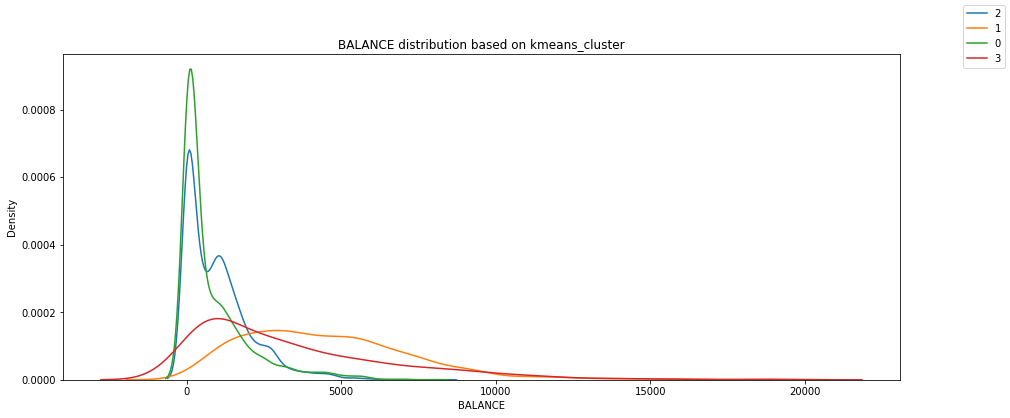

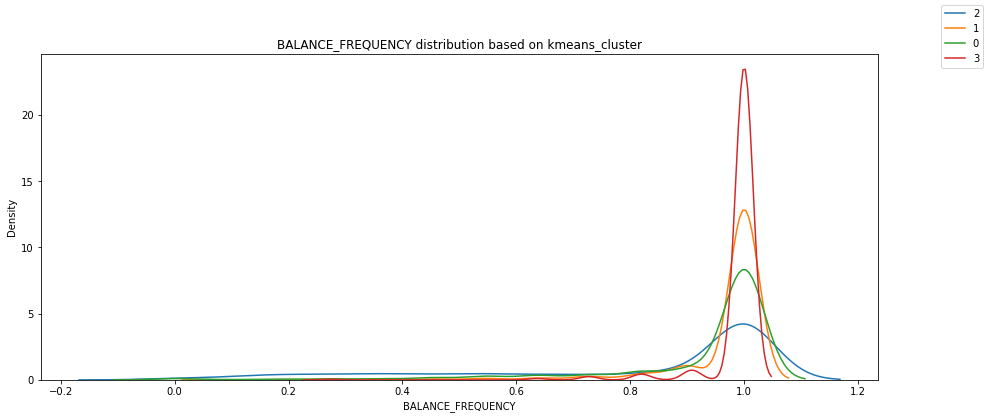

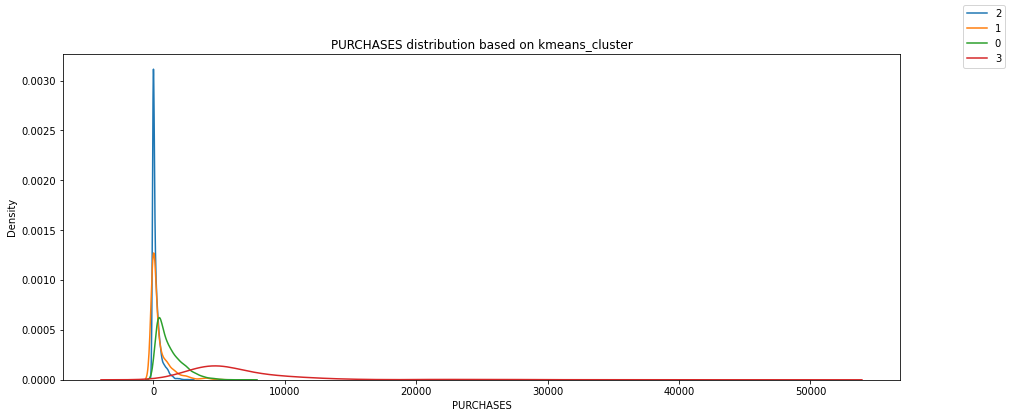

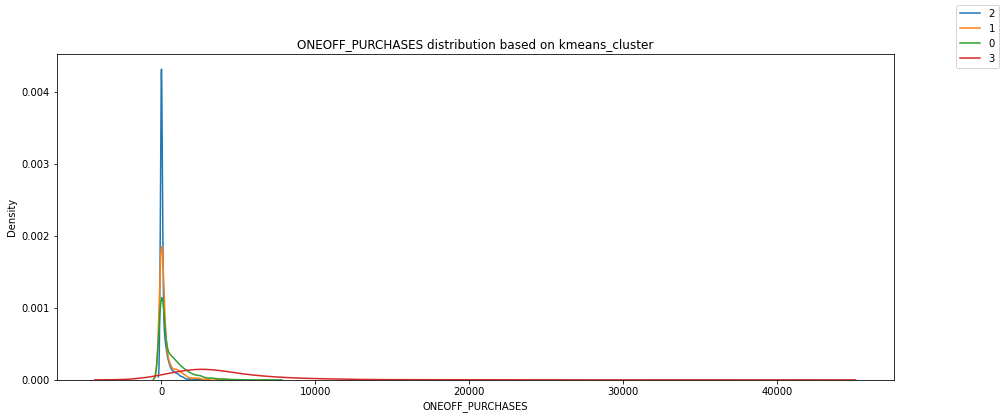

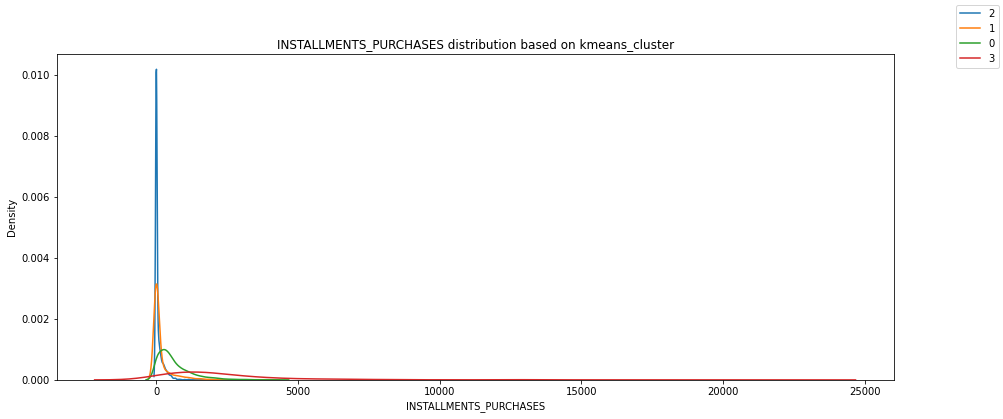

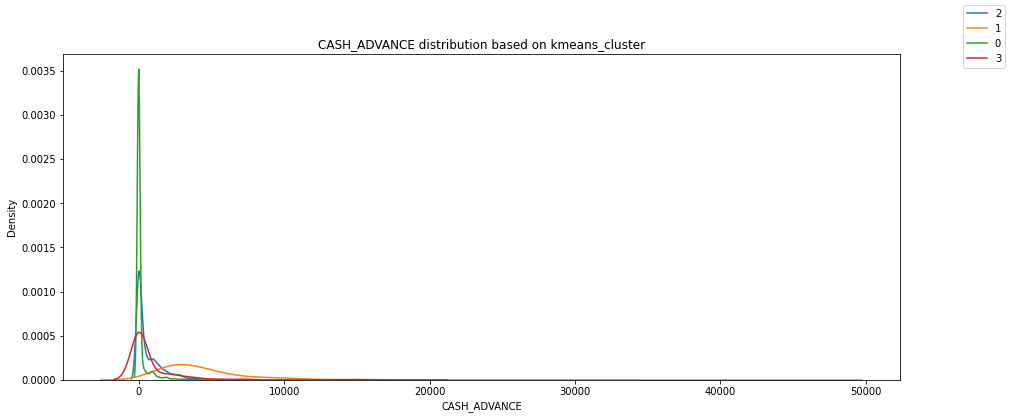

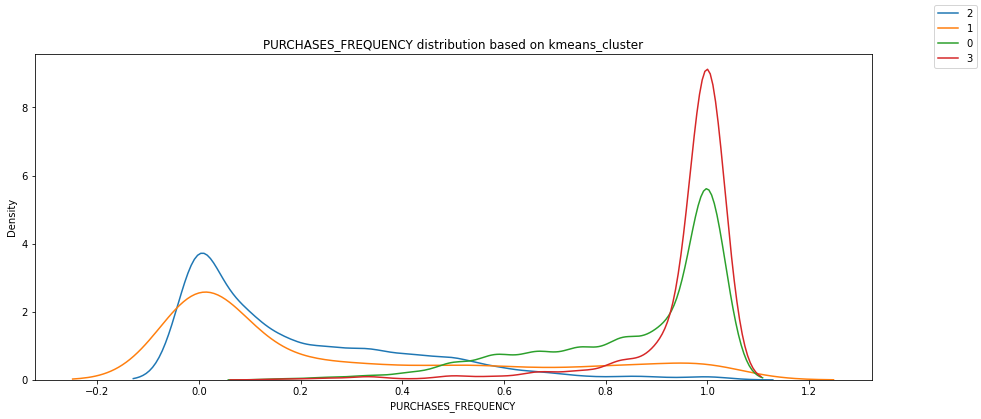

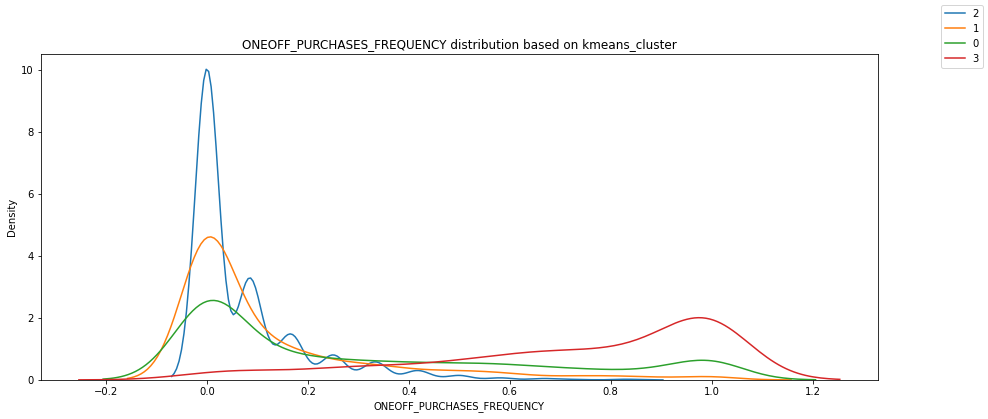

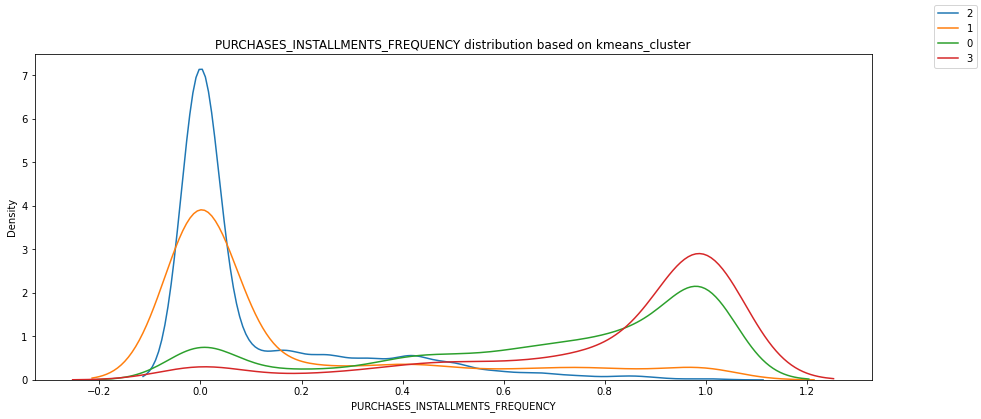

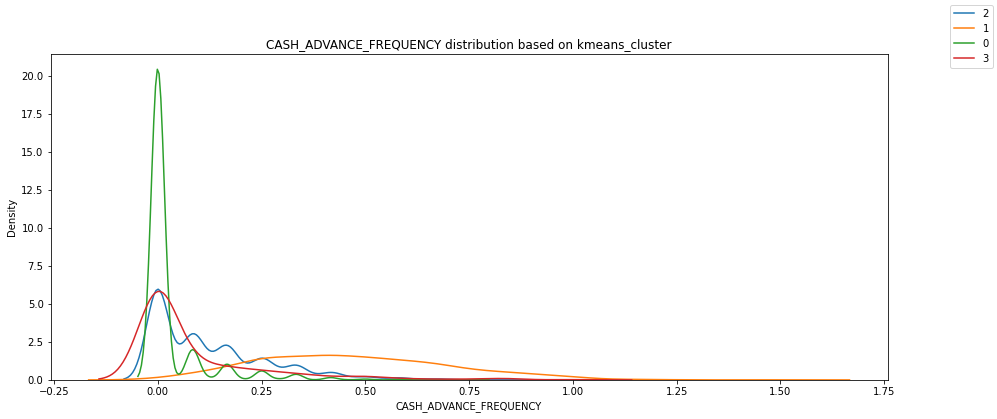

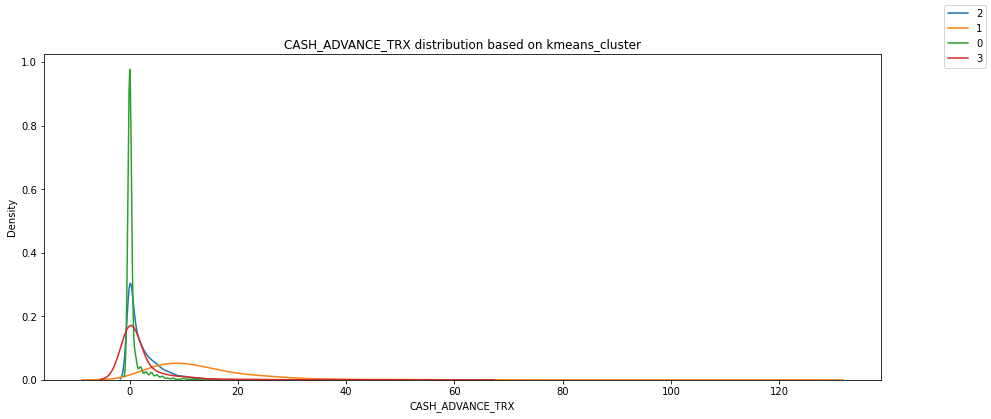

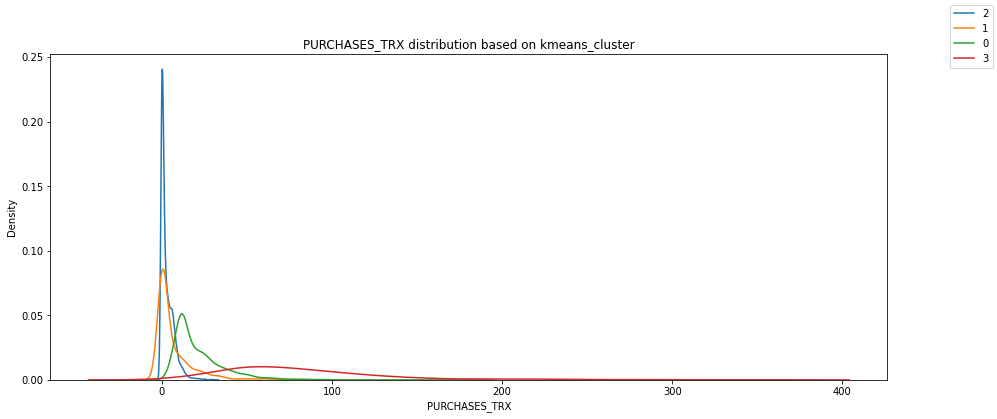

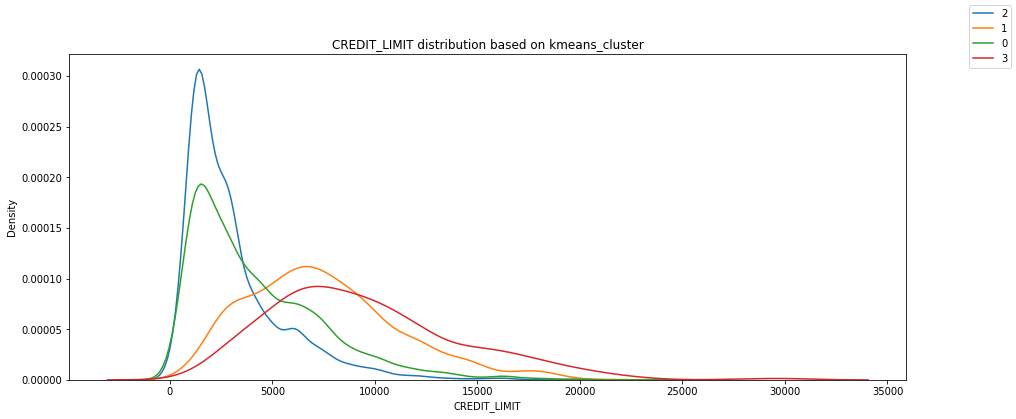

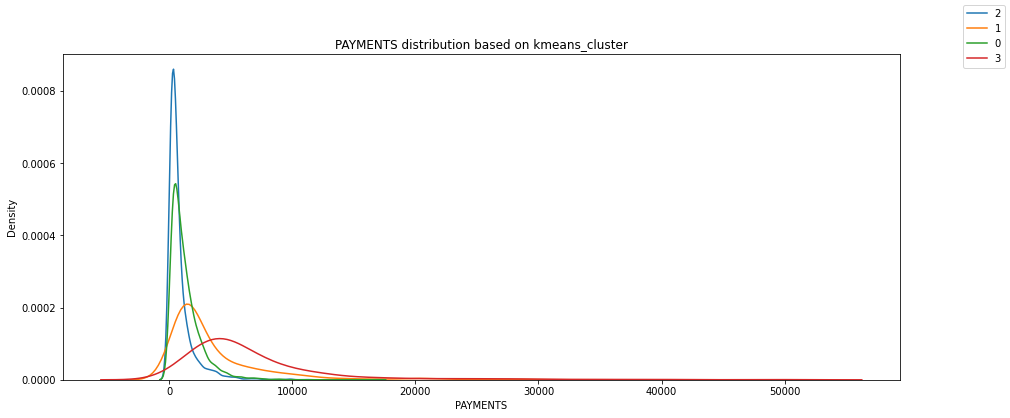

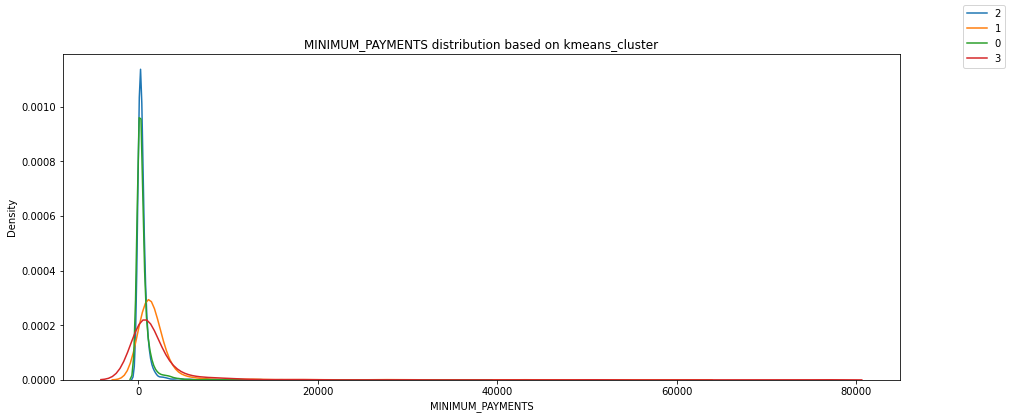

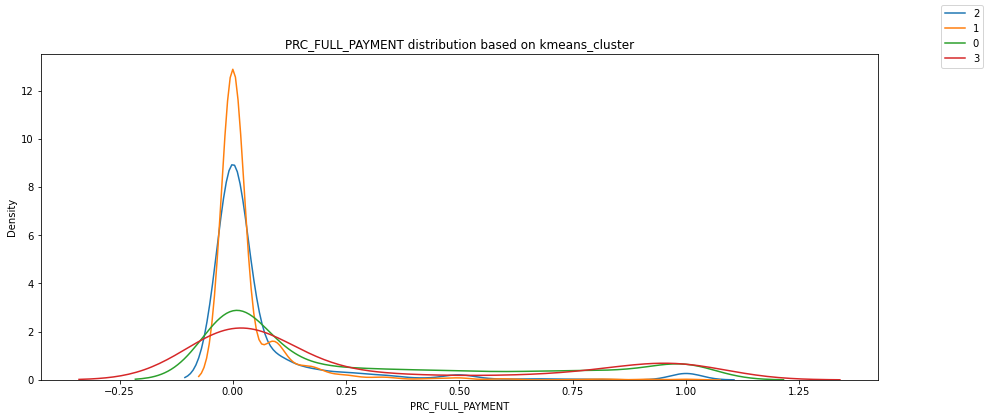

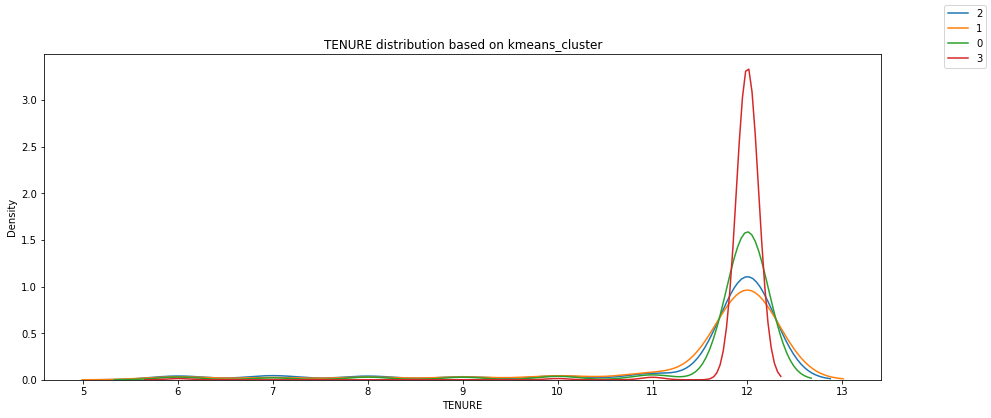

In [34]:
def plot_num_cat(data, feature, target, figsize=None):
    fig = plt.figure(figsize=(15,6))

    for value in data[target].unique():
        sns.kdeplot(data[data[target]==value][feature])

    fig.legend(labels=data[target].unique())
    plt.title('{} distribution based on {}'.format(feature, target))
    plt.show()


for feature in kmeans_data:
    if(feature == 'kmeans_cluster'):
        continue
    plot_num_cat(kmeans_data, feature, 'kmeans_cluster')


c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

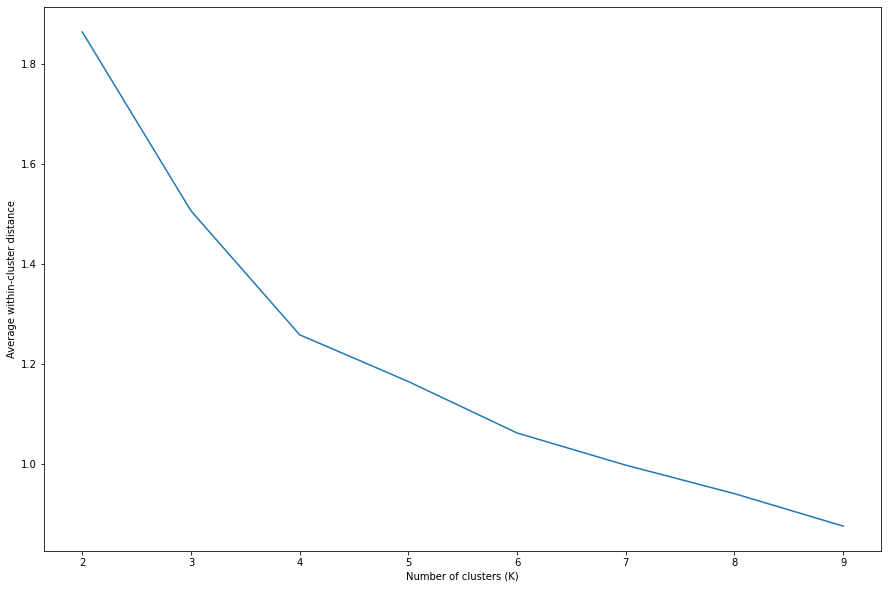

In [35]:
# Evaluation of K-means 
"""
The average within cluster distance is a measure used to evaluate the performance of the K-means algorithm.
It calculates the average distance between the centroid and all the points in the cluster. The idea is that points in the same cluster.
The idea is that points in the same cluster should be close to the centroid, 
so a lower average within clustrer distance indicats better clustering performance
"""

# Calculate within cluster distance

K_values = range(2, 10)  # replace with your desired range of K values
avg_distances = []
plt.figure(figsize=(15,10))
for K in K_values:
    kmeans = KMeans(n_clusters=K, random_state=0).fit(transformed_scaled_data)

    clusters = kmeans.labels_
    centroids = kmeans.cluster_centers_

    total_distance = 0
    total_points = 0

    for i in range(K):
        cluster_points = transformed_scaled_data[clusters == i]
        #print(cluster_points)
        centroid = centroids[i]
        
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        total_distance += np.sum(distances)
        total_points += len(cluster_points)

    avg_within_cluster_distance = total_distance / total_points

    avg_distances.append(avg_within_cluster_distance)

# for index, dist in enumerate(avg_distances):
#     index+=2
#     print(f'(Kmeans) within cluster distance for K = {index}: {dist}')

# Now you can plot the average within-cluster distance for each K value
plt.plot(K_values, avg_distances)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Average within-cluster distance')
plt.savefig("../visualisations/K-means/dataset1_averge_within_cluster_distance.png")
plt.show()

In [36]:
from scipy.spatial import distance
def average_cluster_distance(labels, data):
    unique_labels = np.unique(labels)
    avg_distances = []

    for label in unique_labels:
        if label != -1:  # Ignore noise points
            cluster_points = data[labels == label]
            pairwise_distances = distance.pdist(cluster_points)
            avg_distance = np.mean(pairwise_distances)
            avg_distances.append(avg_distance)

    return avg_distances

Kmeans_avg_distance = average_cluster_distance(cluster_labels , transformed_scaled_data)

for index, dist in enumerate(Kmeans_avg_distance):
    print(f'(Kmeans) Average distance between members of Cluster {index}: {dist}')

(Kmeans) Average distance between members of Cluster 0: 1.5690681320533777
(Kmeans) Average distance between members of Cluster 1: 2.5413506408511957
(Kmeans) Average distance between members of Cluster 2: 1.3428077841759316
(Kmeans) Average distance between members of Cluster 3: 4.059733457794755


In [37]:
from sklearn import metrics

def evaluate_clustering(labels, data):
    # Calculate Silhouette score
    silhouette_score = metrics.silhouette_score(data, labels, metric='euclidean')

    # Calculate Davies-Bouldin Index
    davies_bouldin_index = metrics.davies_bouldin_score(data, labels)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_index = metrics.calinski_harabasz_score(data, labels)

    return silhouette_score, davies_bouldin_index, calinski_harabasz_index


Kmeans_silhouette, Kmeans_davies_bouldin, Kmeans_calinski_harabasz = evaluate_clustering(kmeans.labels_, transformed_scaled_data)

print(f'Kmeans Silhouette score: {Kmeans_silhouette}')
print(f'Kmeans Davies-Bouldin Index: {Kmeans_davies_bouldin}')
print(f'Kmeans Calinski-Harabasz Index: {Kmeans_calinski_harabasz}')

Kmeans Silhouette score: 0.37071646525845686
Kmeans Davies-Bouldin Index: 0.8009906963073018
Kmeans Calinski-Harabasz Index: 6296.72393002026


# DBSCAN

In [38]:
def find_best_eps(data, min_samples):
    # Step 1: Calculate the average distance between each point in the data set and its K nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=min_samples).fit(data)
    distances, indices = nbrs.kneighbors(data)

    # Get the distance to the furthest neighbor (last column of sorted distances)
    k_distances = distances[:, -1]

    # Step 2: Sort distance values by ascending order and plot the K-distance graph
    sorted_distances = np.sort(k_distances)

    # Step 3: Find the elbow point in the graph and use the corresponding distance as Epsilon
    diffs = np.diff(sorted_distances)

    max_diff_index = np.argmax(diffs)
    plt.figure(figsize=(15,10))
    plt.plot(sorted_distances)
    plt.xlabel('Data point index')
    plt.ylabel(f'Distance to {min_samples}-th nearest neighbor')
    plt.yticks(np.arange(min(sorted_distances), max(sorted_distances)+1, 1))

    #plt.plot(max_diff_index, sorted_distances[max_diff_index], 'ro')

    plt.savefig("../visualisations/dbscan/dataset1_best_eps.png")
    plt.show()
    



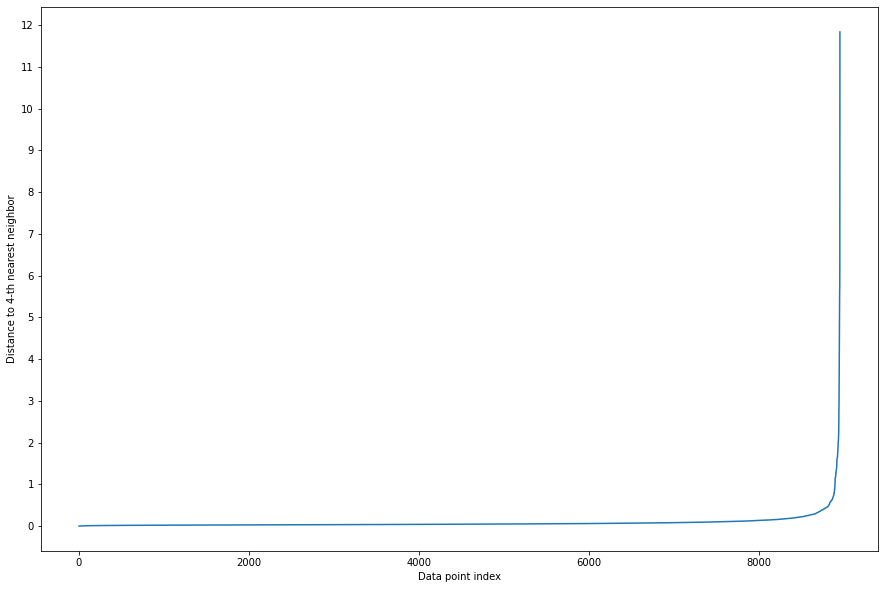

In [39]:
eps = find_best_eps(transformed_scaled_data, min_samples=4)

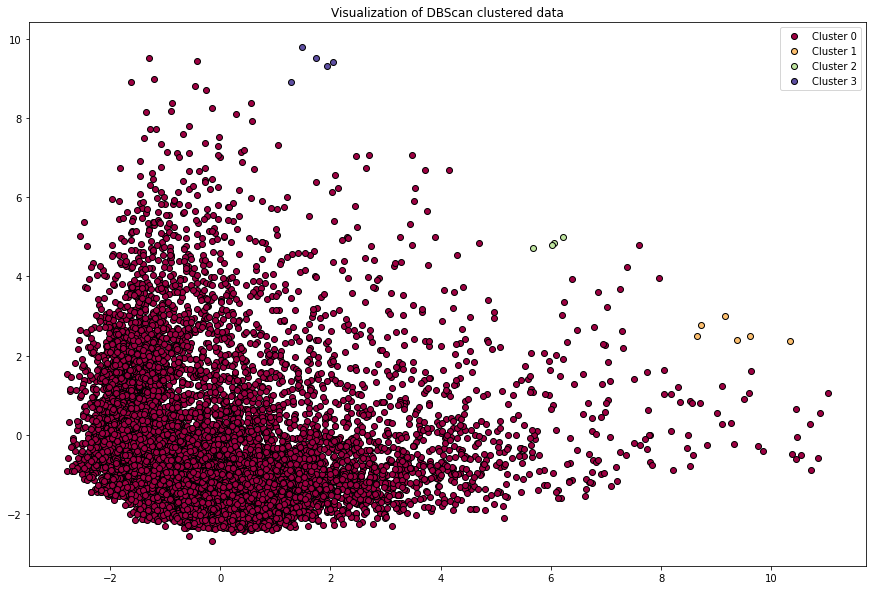

In [40]:
# Best epsilon is determine by the max curvature, which seems to be between 0 and 1 , i will choose 0.75 in this case
dbscan = DBSCAN(eps=0.75, min_samples=4)
dbscan.fit(transformed_scaled_data)
cluster_labels = dbscan.labels_

# Remove noise (label -1) data points
noise_mask = cluster_labels != -1
filtered_data = transformed_scaled_data[noise_mask]
filtered_labels = cluster_labels[noise_mask]

# Calculate silhouette score without noise
dbscan_silhouette = silhouette_score(filtered_data, filtered_labels)
plt.figure(figsize=(15,10))

# Create a scatter plot of the reduced data
unique_labels = set(filtered_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (filtered_labels == k)

    xy = filtered_data[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6, label='Cluster '+str(k))

plt.title('Visualization of DBScan clustered data')
plt.legend()  # Add a legend
plt.savefig("../visualisations/dbscan/dataset1_clusters.png")
plt.show()


In [41]:
# # I see only 4 clusters, lets intepret the results
dbscan_data = data[noise_mask].copy()
dbscan_data['dbscan_cluster'] = filtered_labels


In [42]:
# for c in dbscan_data:
#     grid= sns.FacetGrid(dbscan_data, col='dbscan_cluster')
#     grid.map(plt.hist, c)

In [43]:
cluster_dbscan = dbscan_data.groupby('dbscan_cluster').mean().T
cm = sns.light_palette("green", as_cmap=True)
cluster_dbscan = cluster_dbscan.style.background_gradient(cmap=cm)
cluster_dbscan

dbscan_cluster,0,1,2,3
BALANCE,1520.160815,6466.753336,8916.722111,8040.854592
BALANCE_FREQUENCY,0.876457,1.000000,1.000000,0.945455
PURCHASES,904.046624,10383.828333,7276.347500,669.726000
ONEOFF_PURCHASES,523.414906,5415.053333,5192.107500,338.150000
INSTALLMENTS_PURCHASES,380.934369,4968.775000,2084.240000,331.576000
CASH_ADVANCE,924.864605,1524.320720,3076.907383,17731.524482
PURCHASES_FREQUENCY,0.488009,0.972222,0.812500,0.433333
ONEOFF_PURCHASES_FREQUENCY,0.199349,0.763889,0.437500,0.066667
PURCHASES_INSTALLMENTS_FREQUENCY,0.361929,0.902778,0.708333,0.350000
CASH_ADVANCE_FREQUENCY,0.133163,0.180556,0.395833,0.566667


In [44]:
dbscan_data[dbscan_data['dbscan_cluster']==3]

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,dbscan_cluster
1012,12373.333480,1.000000,830.15,200.00,630.15,10249.92100,0.750000,0.166667,0.583333,0.916667,26,14,11000.0,14040.86635,12245.926010,0.000000,12,3
1710,7445.228843,1.000000,1023.29,0.00,1023.29,16323.64243,1.000000,0.000000,1.000000,0.833333,43,31,11500.0,11320.00746,2739.343539,0.083333,12,3
3555,6744.845686,1.000000,4.44,0.00,4.44,19862.87844,0.250000,0.000000,0.166667,0.416667,11,3,16500.0,21440.29866,1350.823356,0.100000,12,3
6371,4529.895962,0.727273,0.00,0.00,0.00,21943.84942,0.000000,0.000000,0.000000,0.333333,12,0,13000.0,33486.31044,1797.797941,0.428571,12,3
6455,9110.968989,1.000000,1490.75,1490.75,0.00,20277.33112,0.166667,0.166667,0.000000,0.333333,22,5,11000.0,19740.74802,2684.226743,0.000000,12,3


In [45]:
dbscan_data[dbscan_data['dbscan_cluster']==2]

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,dbscan_cluster
263,7755.698607,1.0,8533.54,4072.76,4460.78,7540.307350,1.00,0.50,0.833333,0.500000,12,72,10000.0,4758.209146,7256.951816,0.000000,6,2
669,10359.454710,1.0,12650.00,12650.00,0.00,2781.682203,0.25,0.25,0.000000,0.166667,2,10,10500.0,7566.470234,9170.428051,0.000000,12,2
1817,9303.557117,1.0,6133.01,4045.67,2087.34,1895.608770,1.00,1.00,1.000000,0.833333,23,115,12500.0,4054.579469,2998.465025,0.000000,12,2
4668,8248.178009,1.0,1788.84,0.00,1788.84,90.031207,1.00,0.00,1.000000,0.083333,1,12,18000.0,40627.595240,2149.990102,0.166667,12,2


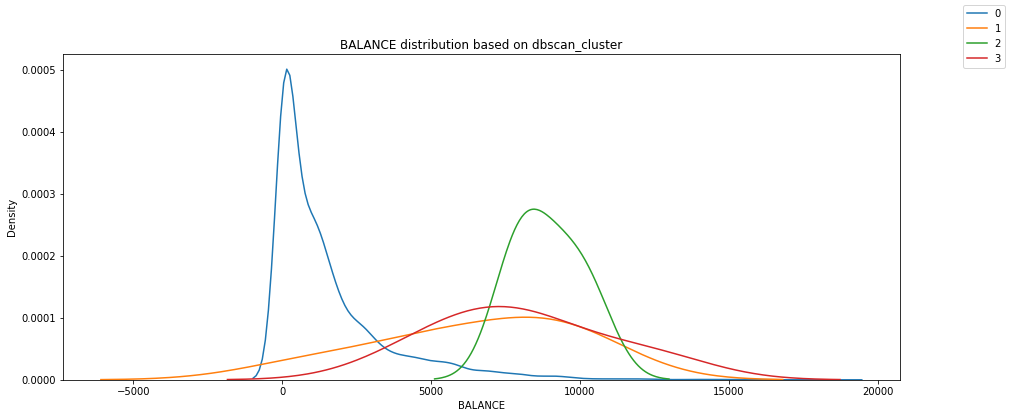

C:\Users\JoeTe\AppData\Local\Temp\ipykernel_12396\3929798507.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data[target]==value][feature])
C:\Users\JoeTe\AppData\Local\Temp\ipykernel_12396\3929798507.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data[target]==value][feature])


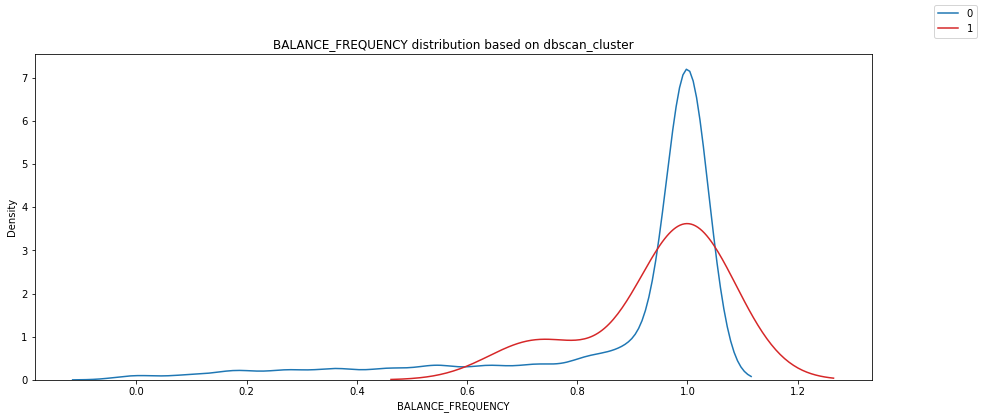

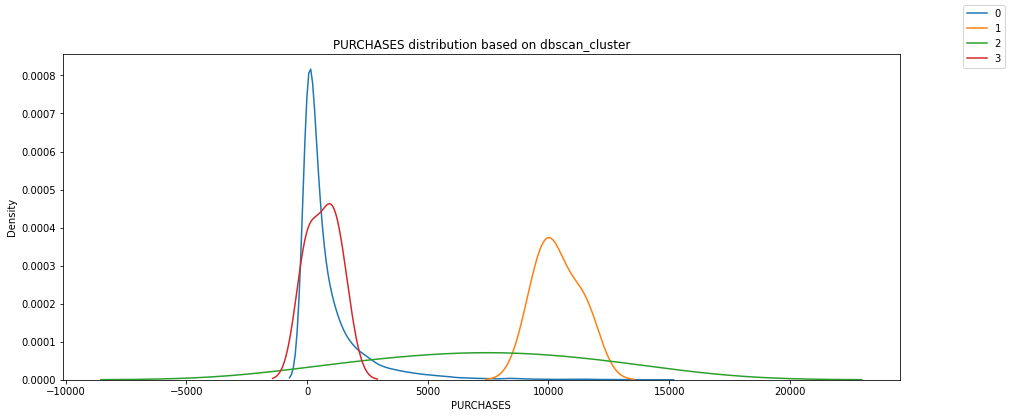

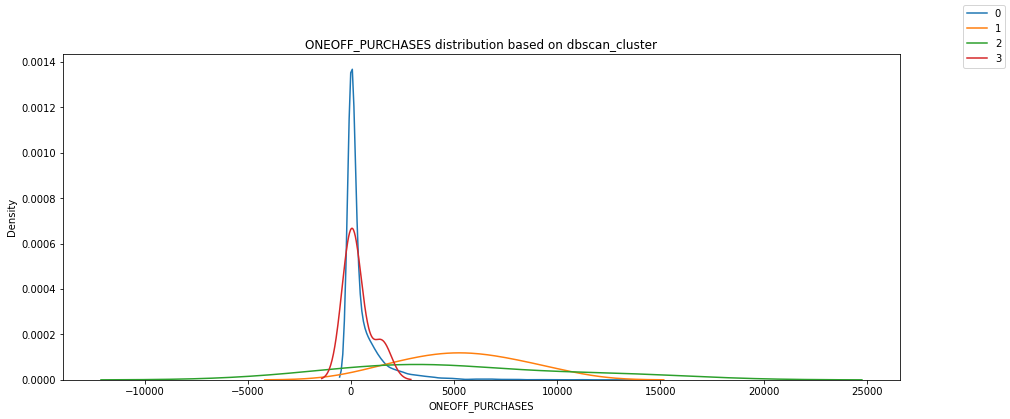

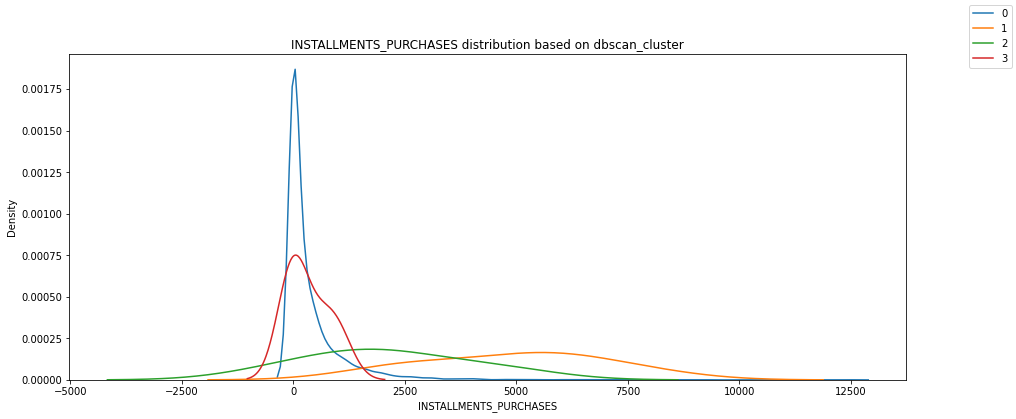

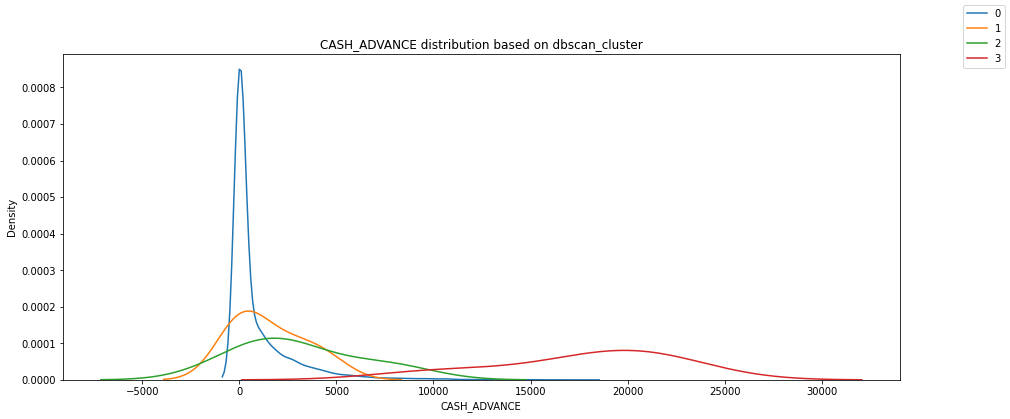

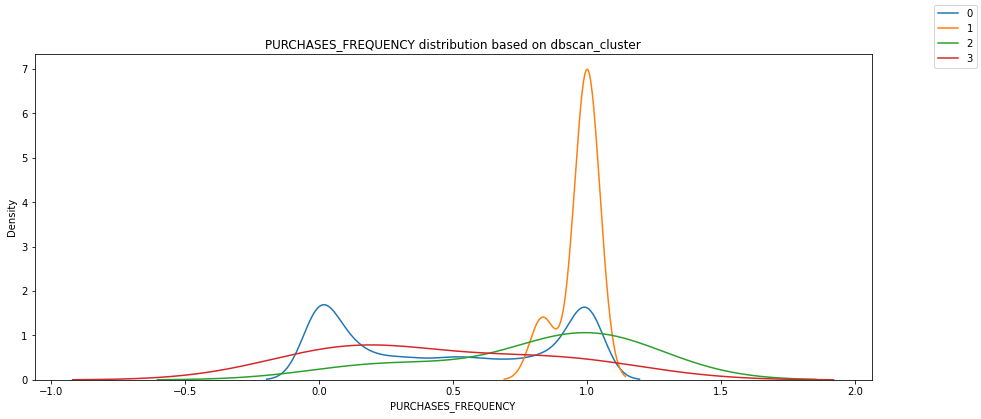

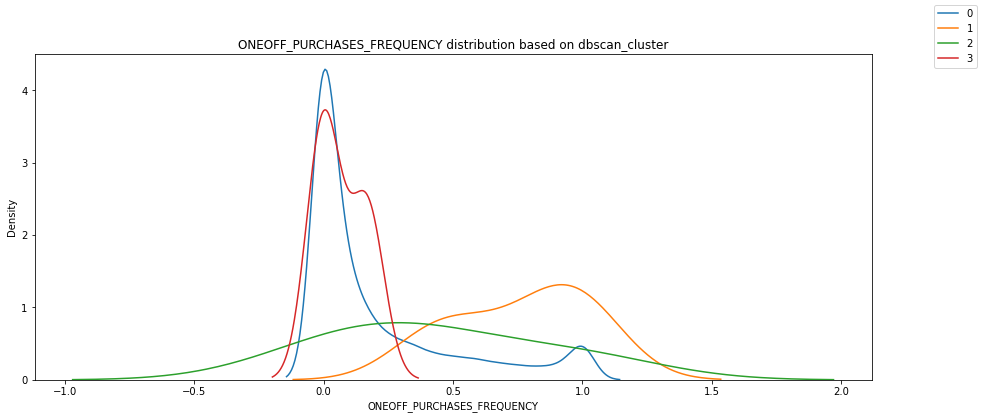

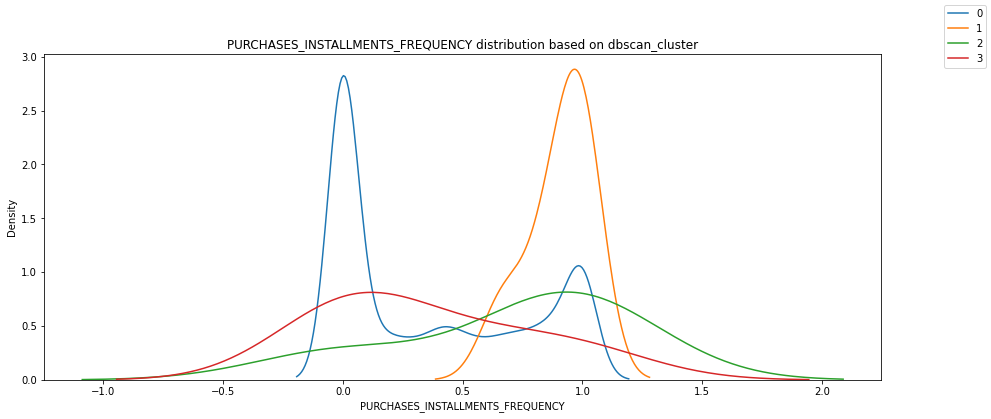

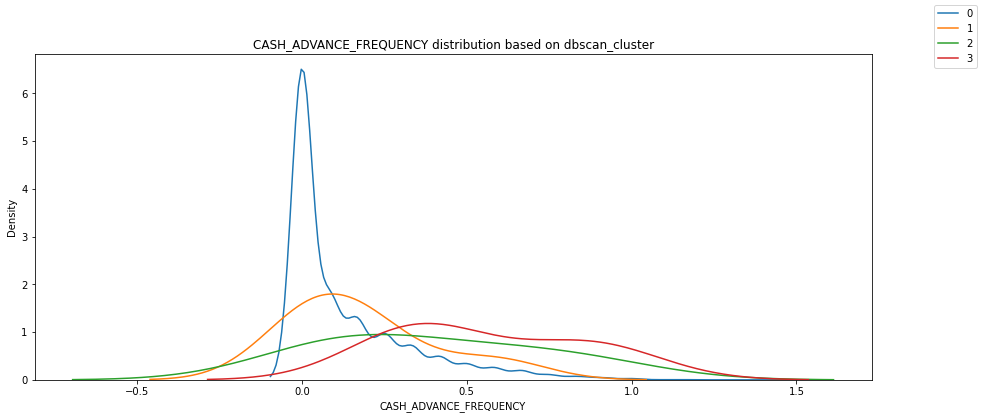

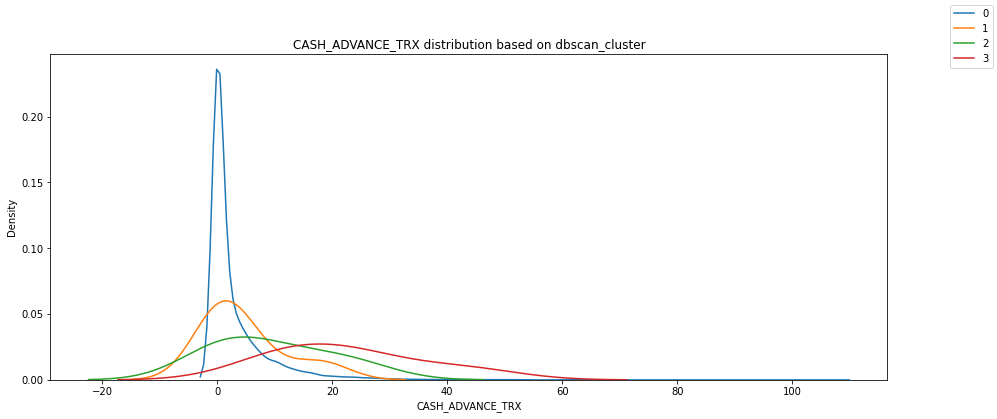

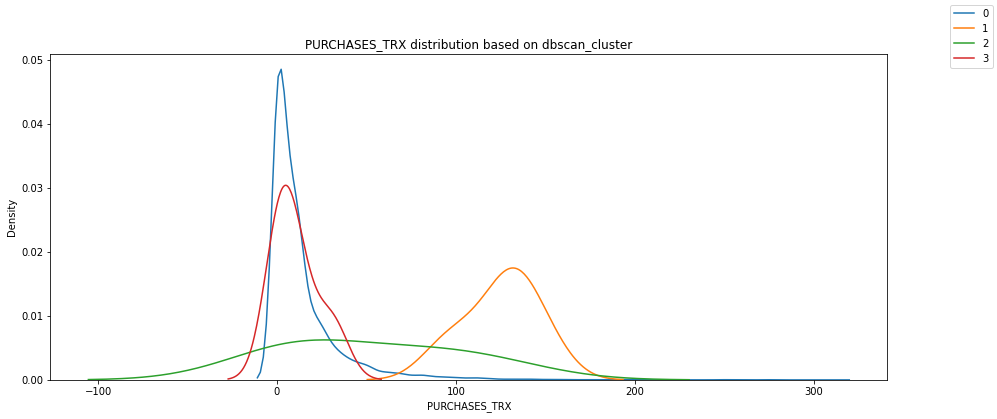

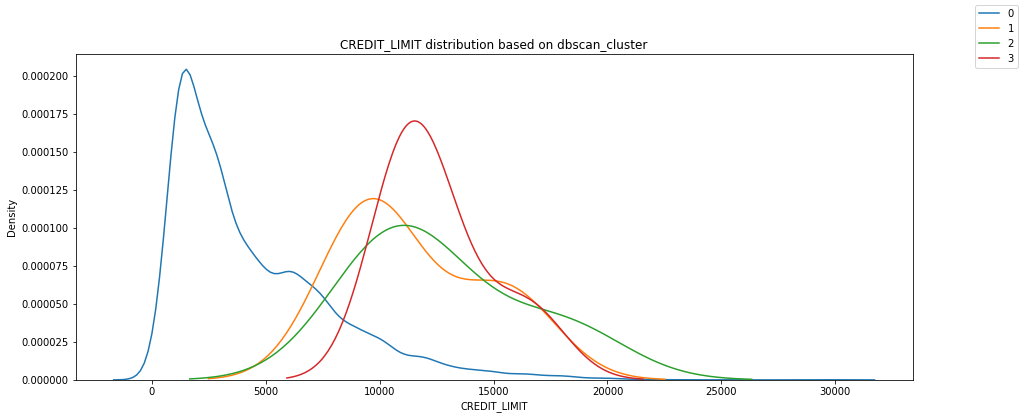

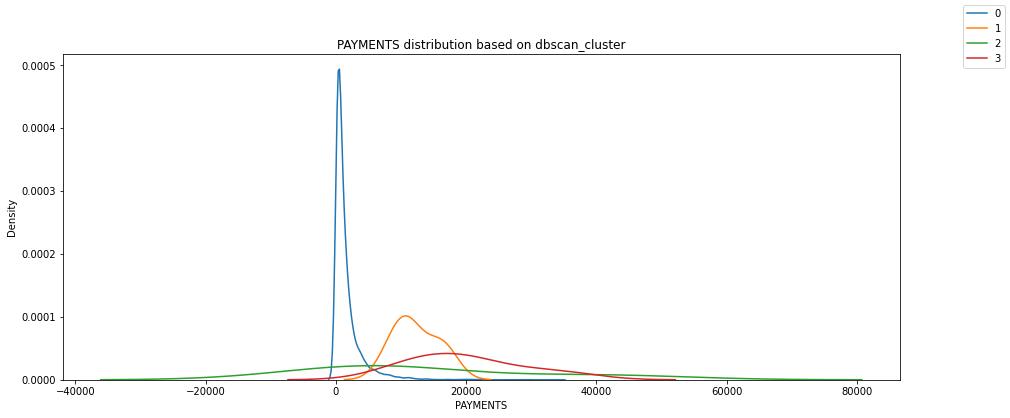

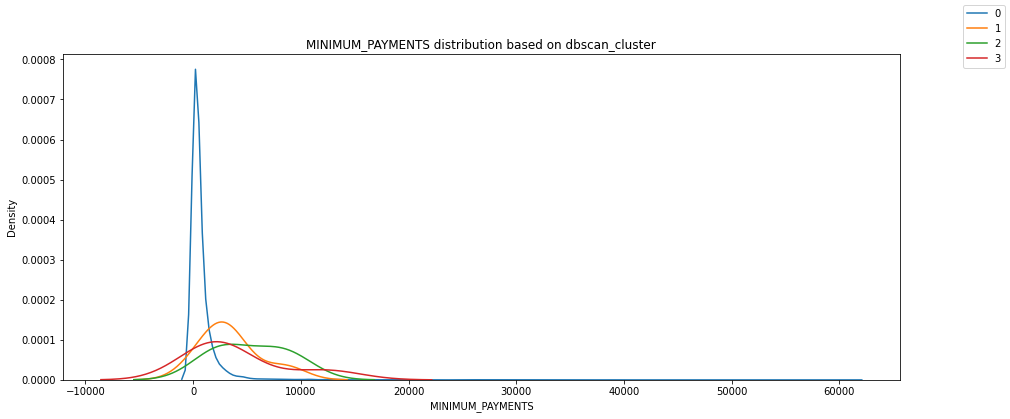

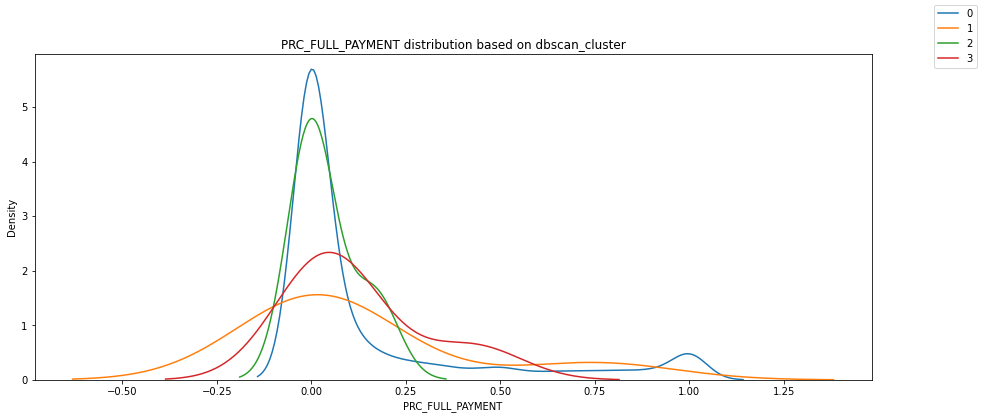

C:\Users\JoeTe\AppData\Local\Temp\ipykernel_12396\3929798507.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data[target]==value][feature])
C:\Users\JoeTe\AppData\Local\Temp\ipykernel_12396\3929798507.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[data[target]==value][feature])


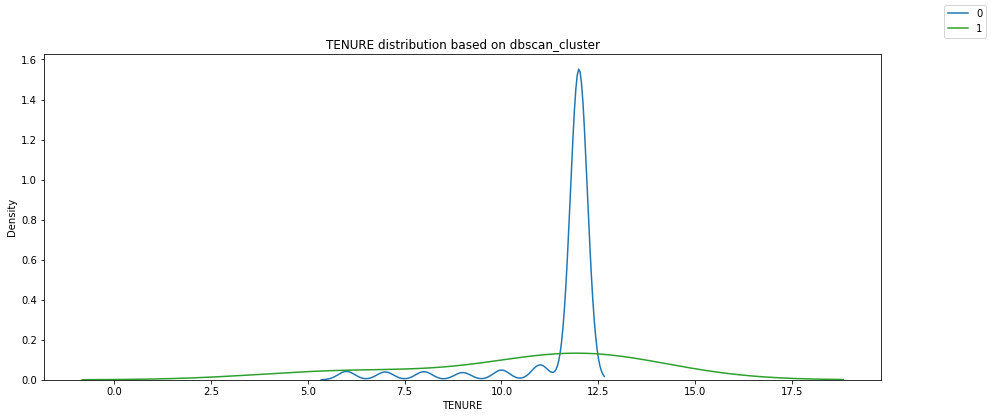

In [46]:
for feature in dbscan_data:
    if(feature == 'dbscan_cluster'):
        continue
    plot_num_cat(dbscan_data, feature, 'dbscan_cluster')

In [47]:
DBSCAN_silhouette, DBSCAN__davies_bouldin, DBSCAN__calinski_harabasz = evaluate_clustering(filtered_labels, filtered_data )

print(f'DBSCAN Silhouette score: {DBSCAN_silhouette}')
print(f'DBSCAN Davies-Bouldin Index: {DBSCAN__davies_bouldin}')
print(f'DBSCAN Calinski-Harabasz Index: {DBSCAN__calinski_harabasz}')

DBSCAN Silhouette score: 0.5885149525757236
DBSCAN Davies-Bouldin Index: 0.28397714411722424
DBSCAN Calinski-Harabasz Index: 66.62839266977697


# K-means ++

c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


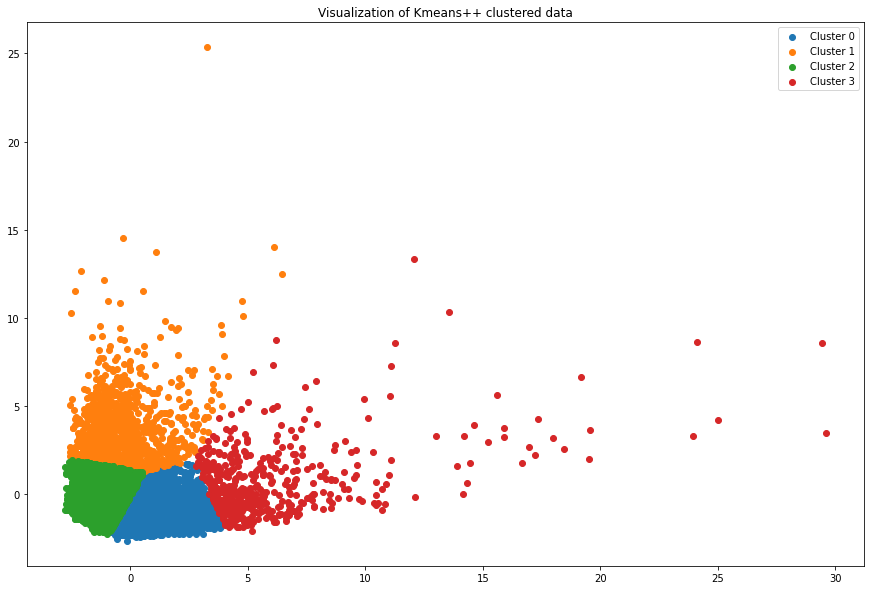

In [48]:
# Number of cluster for K-means to be 4 or 5
k = 4
kmeans_plus = KMeans(n_clusters=k, init='k-means++',random_state=0)
kmeans_plus.fit(transformed_scaled_data)
cluster_labels = kmeans_plus.labels_
kmeans_plus_centroids = kmeans_plus.cluster_centers_
# print(kmeans_plus_centroids)
kmeans_plus_silhouette = silhouette_score(transformed_scaled_data, cluster_labels)
plt.figure(figsize=(15,10))
for i in range(k):
    plt.scatter(transformed_scaled_data[cluster_labels == i, 0], transformed_scaled_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()

# Plot the centroids

#plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of Kmeans++ clustered data')
plt.savefig('../visualisations/K-means/dataset1_kmeans_plus_cluster.png')
plt.show()

c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JoeTe\anaconda3\envs\techfest_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

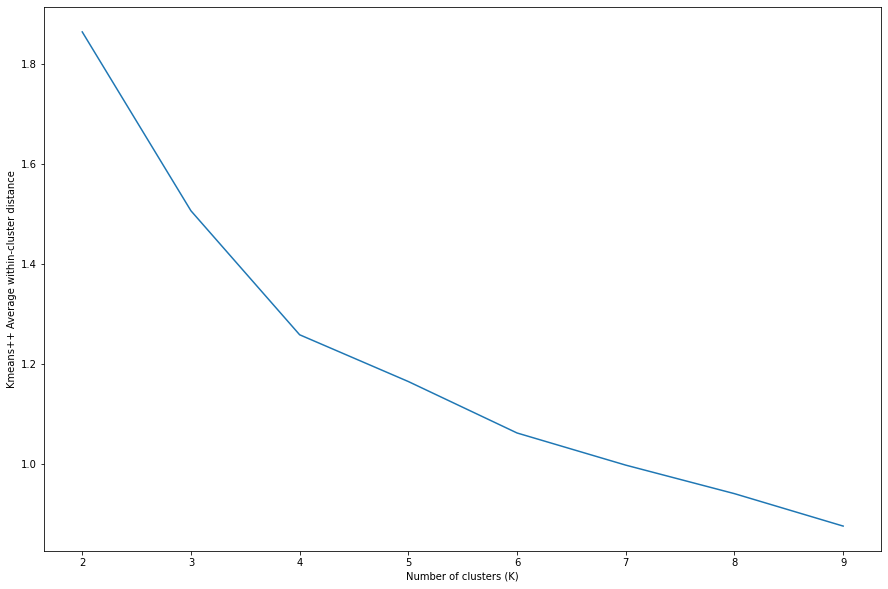

In [49]:
# Calculate within cluster distance

K_values = range(2, 10)  # replace with your desired range of K values
avg_distances = []
plt.figure(figsize=(15,10))
for K in K_values:
    kmeans_plus = KMeans(n_clusters=K, init='k-means++',random_state=0).fit(transformed_scaled_data)
    clusters = kmeans_plus.labels_
    centroids = kmeans_plus.cluster_centers_

    total_distance = 0
    total_points = 0

    for i in range(K):
        cluster_points = transformed_scaled_data[clusters == i]
        #print(cluster_points)
        centroid = centroids[i]
        
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        total_distance += np.sum(distances)
        total_points += len(cluster_points)

    avg_within_cluster_distance = total_distance / total_points

    avg_distances.append(avg_within_cluster_distance)

# for index, dist in enumerate(avg_distances):
#     index+=2
#     print(f'(Kmeans++) within cluster distance for K = {index}: {dist}')

# Now you can plot the average within-cluster distance for each K value
plt.plot(K_values, avg_distances)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Kmeans++ Average within-cluster distance')
plt.savefig("../visualisations/K-means/dataset1_kmeans_plus_averge_within_cluster_distance.png")
plt.show()

In [50]:
Kmeans_plus_silhouette, Kmeans_plus_davies_bouldin, Kmeans_plus_calinski_harabasz = evaluate_clustering(kmeans_plus.labels_, transformed_scaled_data)

print(f'Kmeans++ Silhouette score: {Kmeans_plus_silhouette}')
print(f'Kmeans++ Davies-Bouldin Index: {Kmeans_plus_davies_bouldin}')
print(f'Kmeans++ Calinski-Harabasz Index: {Kmeans_plus_calinski_harabasz}')

Kmeans++ Silhouette score: 0.37071646525845686
Kmeans++ Davies-Bouldin Index: 0.8009906963073018
Kmeans++ Calinski-Harabasz Index: 6296.72393002026
